In [11]:
# main issues:
# fix stop loss/ max wdd
# partial fills
# multiple pairs at one time
# issues with multiple pairs with similar legs, memory management
# trailing profit take
#     1) take 
#     1) sell bad leg and use winning leg to run    

# innovations
# increase volume
# make new models whcih are scalping or momentum models

# kalmans filters
# copulas
# nonlinear distributions
# extreme value theory
# last three are similar
# pair trading with multiple exchanges

# limit orders
# max win drawdown
# advanced risk mitigation 
# if long and first priotirty to get rid off -> sell at market
# if short and first prioity to get rid off -> sell at market
# pair splitting

In [12]:
# imports and requirements
import json
import requests
import pandas as pd
import numpy as np
import ccxt
import time
import datetime as dt
import matplotlib.pyplot as plt

from binance.client import Client
from binance.enums import *

In [13]:
# init client
apiKey = 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh'
apiSecret = 'bsY8Jh1A4jFNv8xLNWbRBff8MPoKQKeyB601YFoSRMiozHRZ4hj3m7pJFcMBIjy5'

# python-binance init
client = Client(apiKey, apiSecret)
# ccxt init
exchange = ccxt.binance({
    'apiKey': 'Xo3vFSsM4XoYge93eqCA3gxmHQTN3rWqOs1LtUsHK9UQDKFcvRp1hMRmIiFIolsh',
    'secret': 'bsY8Jh1A4jFNv8xLNWbRBff8MPoKQKeyB601YFoSRMiozHRZ4hj3m7pJFcMBIjy5',
    'enableRateLimit': True,  # as required by the Manual
    'options': { 'defaultType': 'future' }
})

In [14]:
# inputs
# leg1 = input("Input leg 1: ")
# leg2 = input("Input leg 2: ")
# timeframe = input("Input timeframe/ interval: ")
# emalen = input("Input Lookback/ EMA length: ")
# legval = float(input("Leg Value: "))

leg1 = 'TRXUSDT'
leg2 = 'BATUSDT'
timeframe = '30m'
emalen = '25'
legval = float(input("Leg Value: "))

# convert legs
if leg1 == 'ONTUSDT':
    newLeg1 = 'ONT/USDT'
    # prec = 1 dp, 4 price
elif leg1 == 'ETHUSDT':
    newLeg1 = 'ETH/USDT'
    # prec = 3 dp, 2 price
elif leg1 == 'BCHUSDT':
    newLeg1 = 'BCH/USDT'
    # prec = 3 dp, 2 price
elif leg1 == 'TRXUSDT':
    newLeg1 = 'TRX/USDT'
    # prec = 0 dp, 5 price
    
if leg2 == 'QTUMUSDT':
    newLeg2 = 'QTUM/USDT'
    # prec = 1 dp, 3 price
elif leg2 == 'XTZUSDT':
    newLeg2 = 'XTZ/USDT'
    # prec = 1 dp, 3 price
elif leg2 == 'LTCUSDT':
    newLeg2 = 'LTC/USDT'
    # prec = 3 dp, 2 price
elif leg2 == 'BATUSDT':
    newLeg2 = 'BAT/USDT'
    # prec = 1 dp, 4 price

print("New leg 1:", format(newLeg1))
print("New leg 2:", format(newLeg2))


Leg Value: 5
New leg 1: TRX/USDT
New leg 2: BAT/USDT


In [15]:
# create dataframe
def dataframe(symbol, interval, timeframe):
    rootUrl = 'https://api.binance.com/api/v1/klines'
    url = rootUrl + '?symbol=' + symbol + '&interval=' + interval + '&limit=' + timeframe
    data = json.loads(requests.get(url).text)
    df = pd.DataFrame(data)
    df.columns = ['open_time',
                 'o', 'h', 'l', 'c', 'v',
                 'closeTime', 'qav', 'numTrades',
                 'takerBase_Bol', 'takerQuoteVol', 'ignore']
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.closeTime]
    return df

dataframe(leg1, timeframe, emalen)

,open_time,o,h,l,c,v,closeTime,qav,numTrades,takerBase_Bol,takerQuoteVol,ignore
2020-06-07 06:59:59.999,1591475400000,0.01701000,0.01708000,0.01699000,0.01703000,6487422.90000000,1591477199999,110521.55482200,275,3350268.60000000,57089.76168400,0
2020-06-07 07:29:59.999,1591477200000,0.01703000,0.01705000,0.01700000,0.01704000,3927355.40000000,1591478999999,66878.94517900,170,2001688.50000000,34097.37154800,0
2020-06-07 07:59:59.999,1591479000000,0.01704000,0.01706000,0.01698000,0.01706000,3527689.60000000,1591480799999,60038.77296900,204,1746226.60000000,29732.92155000,0
2020-06-07 08:29:59.999,1591480800000,0.01705000,0.01707000,0.01700000,0.01701000,5363093.50000000,1591482599999,91361.96441400,268,2241216.50000000,38172.99664700,0
2020-06-07 08:59:59.999,1591482600000,0.01702000,0.01703000,0.01695000,0.01698000,8065228.80000000,1591484399999,137006.16793700,315,3291056.30000000,55912.33466800,0
2020-06-07 09:29:59.999,1591484400000,0.01699000,0.01703000,0.01698000,0.01699000,3103027.80000000,1591486199999,52754.18513300,139,1232264.30000000,20953.69904500,0
2020-06-07 09:59:59.999,1591486200000,0.01700000,0.01706000,0.01699000,0.01704000,4299496.50000000,1591487999999,73188.70021200,227,2853371.10000000,48562.69741700,0
2020-06-07 10:29:59.999,1591488000000,0.01704000,0.01706000,0.01701000,0.01705000,5562643.60000000,1591489799999,94744.83604600,256,2946757.60000000,50199.13842700,0
2020-06-07 10:59:59.999,1591489800000,0.01704000,0.01712000,0.01704000,0.01711000,10290469.40000000,1591491599999,175827.30270500,442,7115583.00000000,121600.80671300,0
2020-06-07 11:29:59.999,1591491600000,0.01711000,0.01727000,0.01710000,0.01723000,15632363.50000000,1591493399999,268319.88385000,968,9587447.50000000,164644.81008900,0


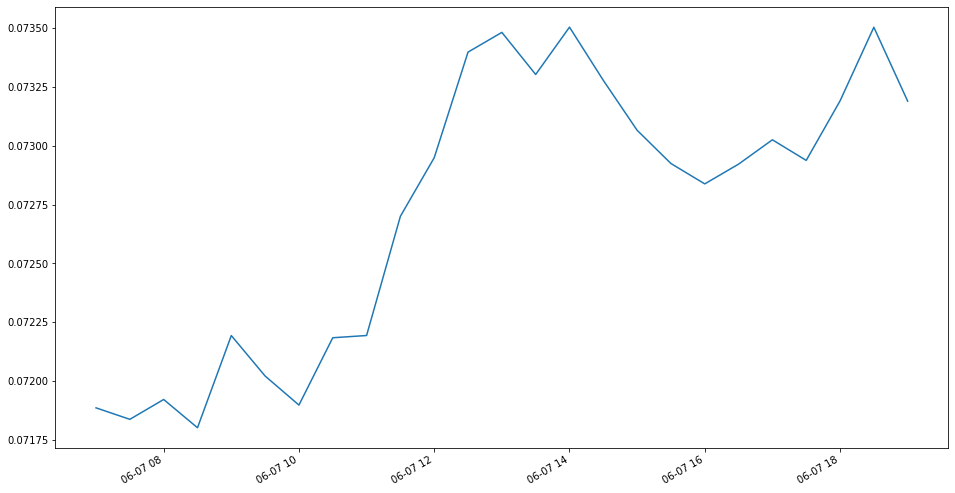

In [16]:
# hedge price function
def priceChart():
    leg1Chart= dataframe(leg1,timeframe, emalen)
    leg2Chart = dataframe(leg2,timeframe, emalen)

    leg1ChartClose = leg1Chart['c'].astype('float')
    leg2ChartClose = leg2Chart['c'].astype('float')

    hedgeChart = leg1ChartClose / leg2ChartClose
    return hedgeChart

# prints price chart
priceChart().plot(figsize=(16,9))

In [17]:
# current zscore
def currZscore():
    currStd = priceChart().std()
    currMean = priceChart().mean()
    a = priceChart().tolist()
    x = a[-1:]
    
    y = [float(i) for i in x]

    zscore = (y[0] - currMean)/currStd
    return round(zscore,5)

print("Current Z-Score = %s" % currZscore())

Current Z-Score = 0.76868


In [18]:
# short buy and long exit
def shortSide(leg1, leg2, legval):
    
    print("Short side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,3)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")


    # short leg1    
    order1 = exchange.createOrder(newLeg1, 'market', 'sell', amountLeg1)
    print("Shorted leg 1")
    print(order1)
    # long leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'buy', amountLeg2)
    print("Longed leg 2")
    print(order2)
    
    inPos = True
    print ("inPos status before exit checks: {}". format(inPos))
    print("-----")

    
    # exit conds
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore <= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'buy', amountLeg1)
            print("Long/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'sell', amountLeg2)
            print("Short/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds for new buy session..."
    entryConds()

In [19]:
# long buy
def longSide(leg1, leg2, legval):
    
    print("Long side function: ...")
    # amount for each leg
    priceLeg1 = dataframe(leg1,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg1 = round(legval/priceLeg1,3)
    print ("Amount of leg1: {}". format(amountLeg1))
    
    priceLeg2 = dataframe(leg2,timeframe,emalen)['c'].astype('float')[-1].tolist()
    amountLeg2 = round(legval/priceLeg2,1)
    print ("Amount of leg2: {}". format(amountLeg2))
    print("-----")
        
    # long leg1
    order1 = exchange.createOrder(newLeg1, 'market', 'buy', amountLeg1)
    print("Longed leg 1")
    print(order1)
    # short leg 2
    order2 = exchange.createOrder(newLeg2, 'market', 'sell', amountLeg2)
    print("Shorted leg 2")
    print(order2)
    print("-----")
    
    inPos = True
    print ("inPos status: {}". format(inPos))
    
    while (inPos == True):
        exZscore = currZscore()
            
        if exZscore >= 0:
            print ("Exiting! Current ZScore: {}". format(exZscore))
            order3 = exchange.createOrder (newLeg1, 'market', 'sell', amountLeg1)
            print("Short/ exited leg 1")
            print(order3)
            order4 = exchange.createOrder (newLeg2, 'market', 'buy', amountLeg2)
            print("Long/ exited leg 2")
            print(order4)
            print("-----")
            inPos = False
            print ("inPos status after exiting: {}". format(inPos))
        else:
            print ("Current ZScore: {}". format(exZscore))
            print("Sleeping 5 secs...")
            print("-----")
            time.sleep(5)
    
    "Calling entryConds"
    entryConds()

In [ ]:
# entry conds
def entryConds():
    entered = False
    print ("Entry status at start of loop: {}". format(entered))
    print("-----")
    
    while entered == False:
        enZscore = currZscore()
        print ("Entry Zscore: {}". format(enZscore))

        if enZscore >= 2:
            print("Entering short side")
            print("-----")
            entered = True
            shortSide(leg1,leg2,legval)
        elif enZscore <= -2:
            print("Entering long side")
            print("-----")
            entered = True
            longSide(leg1,leg2,legval)
        else:
            print("No entry. Sleeping 5 secs...")
            print("-----")
            time.sleep(5)

entryConds()

Entry status at start of loop: False
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.76868
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98646
No entry. Sleeping 5 secs...
-----
Entry Zscore: 0.98939
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.05331
No entry. Sleeping 5 se

Entry Zscore: 1.18702
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.18702
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.18702
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12086
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06155
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06155
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.13708
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06155
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.06155
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.12459
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.17051
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.17051
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.17051
No entry.

Entry Zscore: 1.45286
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.48574
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.48574
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.48574
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.54497
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.48574
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.48574
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.48574
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36502
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36502
No entry.

Entry Zscore: 1.32927
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.39058
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.43528
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.36893
No entry.

Entry Zscore: 1.4425
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.44869
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.44869
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.44869
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.44869
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.50903
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.50903
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.50903
No entry. Sleeping 5 secs...
-----
Entry Zscore: 1.44869
No entry. Sleeping 5 secs...
-----
